# mOWL: Python library for machine learning with ontologies

## Ontology creation:
To get started, you can install mOWL using pip:

In [50]:
!apt install python3-sklearn python3-sklearn-lib
!pip install pystow==0.4.3
!pip install mowl-borg

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


mOWL interfaces the OWL API. For this, we need to interface with the Java Virtual Machine (JVM):

In [51]:
import mowl
mowl.init_jvm("10g")

In [52]:
import os
from java.util import HashSet
from mowl.owlapi import OWLAPIAdapter
from org.semanticweb.owlapi.model import IRI

## Let's create our first ontology

In [53]:
adapter = OWLAPIAdapter()
ontology = adapter.create_ontology("http://mowl/family")

## Class names

In [54]:
male = adapter.create_class("http://Male")
female = adapter.create_class("http://Female")
parent = adapter.create_class("http://Parent")
person = adapter.create_class("http://Person")
mother = adapter.create_class("http://Mother")
father = adapter.create_class("http://Father")
sibling = adapter.create_class("http://Sibling")
brother = adapter.create_class("http://Brother")
sister = adapter.create_class("http://Sister")
son = adapter.create_class("http://Son")
daughter = adapter.create_class("http://Daughter")

## Role names

In [55]:
has_child = adapter.create_object_property("http://hasChild")
has_parent = adapter.create_object_property("http://hasParent")

## Individual names

In [56]:
John = adapter.create_individual("http://John")
Jane = adapter.create_individual("http://Jane")
Robert = adapter.create_individual("http://Robert")
Melissa = adapter.create_individual("http://Melissa")

## Axioms

Let's create some axioms of the form $A \sqsubseteq B$.

In [57]:
axioms = HashSet()
axioms.add(adapter.create_subclass_of(male, person))
axioms.add(adapter.create_subclass_of(female, person))
axioms.add(adapter.create_subclass_of(parent, person))
axioms.add(adapter.create_subclass_of(mother, female))
axioms.add(adapter.create_subclass_of(father, male))

True

Now, let's create some axioms of the form $A \sqcap B \sqsubseteq C$.

In [58]:
parent_and_male = adapter.create_object_intersection_of(parent, male)
axioms.add(adapter.create_subclass_of(parent_and_male, father))
parent_and_female = adapter.create_object_intersection_of(parent, female)
axioms.add(adapter.create_subclass_of(parent_and_female, mother))

True

Now some axioms of the form $A \sqcup B \equiv C$.

In [59]:
male_or_female = adapter.create_object_union_of(male, female)
axioms.add(adapter.create_equivalent_classes(male_or_female, person))

True

One axiom of the form $\neg A \equiv  B$.

In [60]:
not_male = adapter.create_complement_of(male)
axioms.add(adapter.create_equivalent_classes(not_male, female))

True

One axiom of the form $A \sqsubseteq \exists R.B$.

In [61]:
has_child_person = adapter.create_object_some_values_from(has_child, person)
axioms.add(adapter.create_subclass_of(parent, has_child_person))

True

And finally, some assertion axioms of the form $C(a)$ and $R(a,b)$.

In [62]:
axioms.add(adapter.create_class_assertion(father, John))
axioms.add(adapter.create_class_assertion(mother, Jane))
axioms.add(adapter.create_class_assertion(male, Robert))
axioms.add(adapter.create_class_assertion(female, Melissa))
axioms.add(adapter.create_object_property_assertion(has_child, John, Robert))
axioms.add(adapter.create_object_property_assertion(has_child, Jane, Robert))
axioms.add(adapter.create_object_property_assertion(has_child, John, Melissa))
axioms.add(adapter.create_object_property_assertion(has_child, Jane, Melissa))
adapter.owl_manager.addAxioms(ontology, axioms)

<java object 'org.semanticweb.owlapi.model.parameters.ChangeApplied'>

In [63]:
ont_file = os.path.abspath(f'family.owl')

In [64]:
adapter.owl_manager.saveOntology(ontology, IRI.create('file://'+ont_file))

In [65]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/mowl-tutorial/")

ModuleNotFoundError: No module named 'google.colab'

# Ontology projections into graphs

Ontologies are formed by a TBox, an ABox and an RBox. A Knowledge
Graph can be easily extracted from the ABox and the RBox. However, to
encode the graph representation of the TBox, which is composed by
(complex) concept descriptions, many approaches have been developed. In mOWL, we provide some
methods that perform ontology projection into graphs:

- **Taxonomy projection**: the projection of axioms of the form $A
\sqsubseteq B$ as edges $(A, subclassof, B)$.

- **Taxonomy + relations**: the projection of axioms of the form $A
\sqsubseteq B$ and $A \sqsubseteq \exists R.B$ as edges $(A,
subclassof, B)$ and $(A, R, B)$, respectively.

- **DL2Vec projection**

- **OWL2Vec projection**

In [66]:

import mowl
mowl.init_jvm("10g")

from mowl.projection import TaxonomyProjector, TaxonomyWithRelationsProjector, DL2VecProjector, OWL2VecStarProjector

In [67]:
#from mowl.datasets.builtin import FamilyDataset
from mowl.datasets import PathDataset
#dataset = FamilyDataset()
dataset = PathDataset("family.owl")
edges = TaxonomyProjector().project(dataset.ontology)

INFO: Number of ontology classes: 6


In [68]:
def nx_network(edges):
    import networkx as nx
    import matplotlib.pyplot as plt
    G = nx.DiGraph()
    for edge in edges:
        src = edge.src.split("/")[-1]
        dst = edge.dst.split("/")[-1]
        G.add_edge(src, dst)
    #nx draw with custom colors
    plt.figure(figsize=(5,5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='cyan', alpha=0.9,
            labels={node:node for node in G.nodes()})
    #nx.draw(G, with_labels=True)
    plt.show()

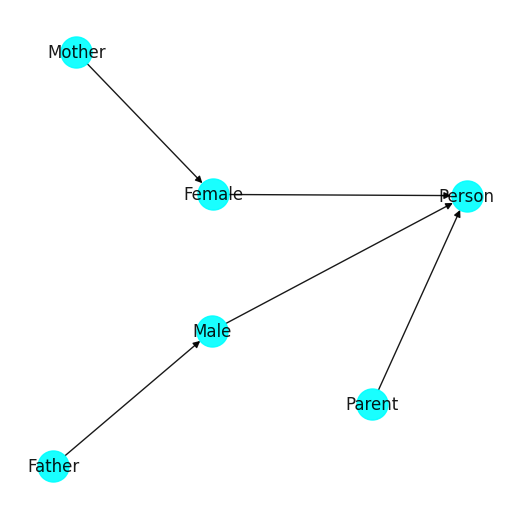

In [69]:
nx_network(edges)

In [70]:
dl2vec_proj = DL2VecProjector(bidirectional_taxonomy=True)
d2v_edges = dl2vec_proj.project(dataset.ontology, with_individuals=True)

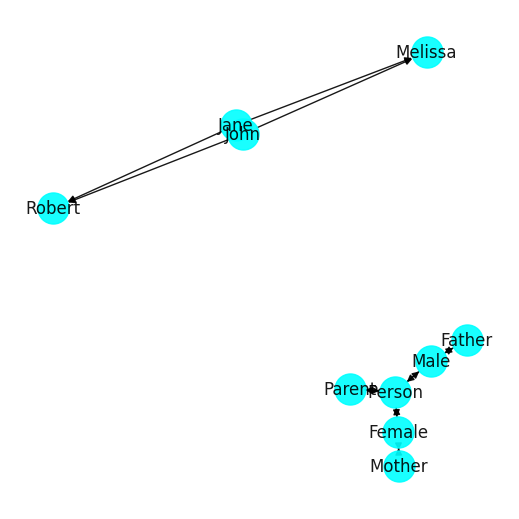

In [71]:
nx_network(d2v_edges)

In [72]:
owl2vec_proj = OWL2VecStarProjector(bidirectional_taxonomy=True)
o2v_edges = owl2vec_proj.project(dataset.ontology)

subRoles: Map()
inverseRoles: Map()


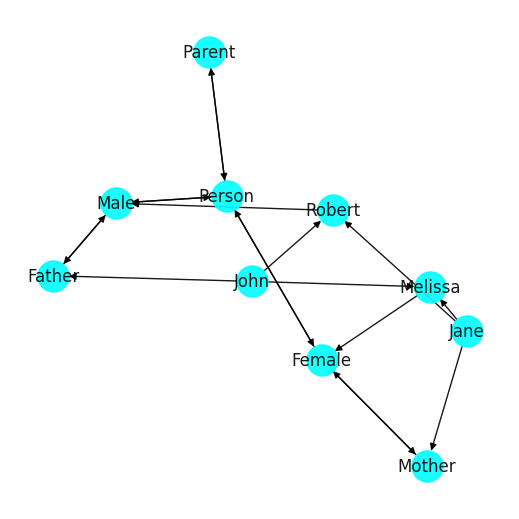

In [73]:
nx_network(o2v_edges)

# Random-walk-based embeddings of ontologies

After generating the graph, we can embed it in different ways. Two approaches are supported in mOWL: 
- Embeddings based on random walks
- Embeddings based on KGE

Let's try the approach with random walks.

In [74]:
from mowl.walking.deepwalk.model import DeepWalk
walker =  DeepWalk(
             10, #num_walks,
             4, #walk_length,
             0.1, #alpha
             outfile = "walks_dw.txt", # /optional/path/to/save/walks,
             workers = 4)
walker.walk(o2v_edges)

Starting pool...
+ started processing thread 1
+ started processing thread 0
+ started processing thread 2
+ started processing thread 3
- finished processing thread 1 after 38
- finished processing thread 3 after 40
- finished processing thread 0 after 41
- finished processing thread 2 after 42
* Walking is done, shutting down the executor


## Process the walks using Word2Vec

In [75]:
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec

walk_corpus_file = walker.outfile
sentences = LineSentence(walk_corpus_file)

w2v_model = Word2Vec(sentences, vector_size = 2) #vector_size/size

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 15 word types from a corpus of 700 raw words and 100 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 15 unique words (100.00% of original 15, drops 0)', 'datetime': '2023-08-28T13:04:09.720047', 'gensim': '4.3.0', 'python': '3.9.15 (main, Nov 24 2022, 14:31:59) \n[GCC 11.2.0]', 'platform': 'Linux-5.4.0-152-generic-x86_64-with-glibc2.31', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 700 word corpus (100.00% of original 700, drops 0)', 'datetime': '2023-08-28T13:04:09.720749', 'gensim': '4.3.0', 'python': '3.9.15 (main, Nov 24 2022, 14:31:59) \n[GCC 11.2.0]', 'platform': 'Linux-5.4.0-152-generic-x86_64-with-glibc2.31', 'event': 'prepa

In [76]:
w2v_model.wv.most_similar("http://Jane")

[('http://Father', 0.9913138151168823),
 ('http://Male', 0.9862878918647766),
 ('http://Person', 0.9847211241722107),
 ('http://hasChild', 0.931801974773407),
 ('http://superclassof', 0.1991695612668991),
 ('http://type', 0.09203178435564041),
 ('http://John', -0.3351083993911743),
 ('http://Melissa', -0.5720320343971252),
 ('*****', -0.7732809782028198),
 ('http://subclassof', -0.8508251905441284)]

## Task 🚧

We will add a new axiom in the ontology:  $hasChild(John,Bob)$. We know that Jhon and Jane already have two children. Can we infer that Bob is also related to Jane?

In [77]:
Bob = adapter.create_individual("http://Bob")
axioms.add(adapter.create_object_property_assertion(has_child, John, Bob))
adapter.owl_manager.addAxioms(ontology, axioms)
ont_file = os.path.abspath(f'family2.owl')
adapter.owl_manager.saveOntology(ontology, IRI.create('file://'+ont_file))

In [79]:
dataset = PathDataset("family2.owl")
projector = OWL2VecStarProjector(bidirectional_taxonomy=True) # YOUR CODE HERE
new_edges = projector.project(dataset.ontology)

subRoles: Map()
inverseRoles: Map()


In [80]:
walker =  DeepWalk(
             10, #number of walks,
             10, #walk length,
             "your number here", #alpha: restart parameter
             outfile = "walks_dw.txt", # /optional/path/to/save/walks,
             workers = 4)

walker.walk(new_edges)
walk_corpus_file = walker.outfile
sentences = LineSentence(walk_corpus_file)
w2v_model = Word2Vec(sentences, vector_size=5)

TypeError: Parameter num_walks must be an integer

In [ ]:
w2v_model.wv.most_similar("http://Jane")



# Use case: Gene-Disease association prediction


In [ ]:
# built-in imports


import numpy as np
from mowl.datasets.builtin import GDAMouseDataset
from mowl.evaluation.rank_based import EmbeddingsRankBasedEvaluator
from mowl.evaluation.base import CosineSimilarity
from gensim.models import Word2Vec
from mowl.projection import TaxonomyWithRelationsProjector

import warnings  
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')  
warnings.filterwarnings(action='ignore',category=FutureWarning,module='gensim') 

# Dataset 

Build your own dataset

In [ ]:
from mowl.ontology.extend import insert_annotations
 
diseases_annotations = ("diseases_annot.tsv", "http://has_annotation", True) 
genes_annotations = ("genes_annot.tsv", "http://has_annotation", True) 
gene_disease_associations = ("gene_disease_associations.tsv","http://is_associated_with/", True) 

annotations = [diseases_annotations , genes_annotations, gene_disease_associations] # There could be more than 1 annotations file. 

insert_annotations("upheno.owl", annotations, out_file = "upheno_with_annotations.owl" )

Use the Built-in Dataset

In [ ]:
dataset = GDAMouseDataset()

The dataset will be downloaded to a folder name `gda_mouse` with the training, validation and testing ontology dataset

In [ ]:
! ls gda_mouse/

# Graph-based embeddings

 ### Example for two methods: DL2vec and Owl2vec* methods

<font color='blue'><font size="4">1) DL2vec Prediction Method </font></font>


1. **Projecting the ontology** 
- Project the ontology using the DL2Vec Projector class, with the specific rules used to project the ontology. 
- The outcome of the projection algorithm is an edgelist.



In [ ]:
from mowl.projection.dl2vec.model import DL2VecProjector 
projector = DL2VecProjector(True)
train_edges = projector.project(dataset.ontology)
test_edges = projector.project(dataset.testing)

2. **Generating random walks**
- The random walks are generated using the DeepWalk.


In [ ]:
walker = DeepWalk(10, # number of walks per node
                  10, # walk length
                  0.1, # restart probability
                  workers=4, outfile = 'walk',seed=40) # number of threads

walks = walker.walk(train_edges)
walks_file = walker.outfile
sentences = LineSentence(walks_file)

3. **Training the Word2Vec model**
- To train the Word2Vec model, we rely on the Gensim library

In [ ]:
model = Word2Vec(sentences, vector_size=100, epochs = 15, window=5, min_count=1, workers=10)

4. **Evaluating the embeddings** 
- We are going to evaluate the plausibility of an association gene-disease with a gene against all possible diseases and check the rank of the true disease association using CosineSimilarity.


In [ ]:
genes, diseases = dataset.evaluation_classes
projector = TaxonomyWithRelationsProjector(taxonomy=False,
                                           relations=["http://is_associated_with"])

vectors = model.wv
evaluator = EmbeddingsRankBasedEvaluator(
    vectors,
    test_edges,
    CosineSimilarity,
    training_set=train_edges,
    head_entities = genes.as_str,
    tail_entities = diseases.as_str,
    device = 'cpu')


evaluator.evaluate(show=True)

In [ ]:
human_disease=[]
mouse_genes=[]
for classes in vectors.index_to_key:
    if 'OMIM' in classes:
        human_disease.append(classes)
    if classes[7:].isnumeric():
        mouse_genes.append(classes)

print(f'Number of the disease is {len(human_disease)}, and number of genes is {len(mouse_genes)}')

In [ ]:
human_disease[:10]

In [ ]:
mouse_genes[:10]

In [ ]:
human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors[k])

from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))

print(f"The dimentions of this matrix is {similarity.shape}")

## Evaluating the predictions to find the most similar genes:

In [ ]:
def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes

#associations from the file MGI_DO.rpt

      
#DOID:0080449	developmental and epileptic encephalopathy 16	OMIM:615338	mouse, laboratory	10090	Tbc1d24	224617	MGI:2443456
disease_id = 'http://OMIM_615338' 
top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')

      
#DOID:0080436	developmental and epileptic encephalopathy 4	OMIM:612164	human	9606	STXBP1	6812	
#DOID:0060309	syndromic X-linked intellectual disability		human	9606	HNRNPH2	3188	
#HNRNPH2	3188	Hnrnph2	MGI:1201779	MP:0001186, MP:0005386, MP:0010771	      
#disease_id = 'http://OMIM_612164' 
#top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
#print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')


#OMIM_181500 : schizophrenia : DOID:5419	OMIM:181500	mouse, laboratory	10090	Magi2	50791	MGI:1354953
#disease_id = 'http://OMIM_181500' 
#top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
#print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')
      

#OMIM_615643 : neurodegeneration with brain iron accumulation 6
#DOID:0110740	OMIM:615643	mouse, laboratory	10090	Coasy	71743	MGI:1918993
#disease_id = 'http://OMIM_615643' 
#top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
#print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')

In [ ]:
def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes

disease_id = 'http://OMIM_615643' 
top_k = find_similar_genes(disease_id, 5 ,similarity, human_disease, mouse_genes )
print(f'The most similar gene to disease {disease_id.split("/")[2]} are: {top_k}')

-------------------------------------

# **Task 1 :**

<div class="alert alert-block alert-success" , color ='grreen'> 

<font size="4"> 
    Predict the <font color='SteelBlue'>top 10 similar genes</font> to 
    diabetes mellitus disease OMIM ID: <font color='Tomato'>http://OMIM_608036</font>
    using <font color='red'>OWL2vec*</font> prediction method

</font>

</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> Follow the <b>TODO</b> interactions to modify the script, and the rest should be the same you just need to run the cell to execute the code.
</div>


----

<font color='blue'><font size="4">2) OWL2vec* Prediction Method </font></font> 


1. **Projecting the ontology** 
- Project the ontology using the OWL2Vec* Projector class, with the specific rules used to project the ontology. 
- The outcome of the projection algorithm is an edgelist.


In [ ]:
from mowl.projection import #TODO: import the appropriate function (refer to https://mowl.readthedocs.io/en/latest/api/projection/index.html)
dataset = GDAMouseDataset()
projector = OWL2VecStarProjector(True)
train_edges = projector.project(dataset.ontology)
test_edges = projector.project(dataset.testing)

2. **Generating random walks**
- The random walks are generated using the DeepWalk.


In [ ]:
walker = DeepWalk( ,#TODO: add the number of walks per node
                   ,#TODO: add the walk length
                  workers=4, # number of threads
                  outfile = , #TODO: add the name of the output file for the walks
                  seed=40) #fix the random seed 

walks = walker.walk(train_edges)
walks_file = walker.outfile
sentences = LineSentence(walks_file)

3. **Training the Word2Vec model**
- To train the Word2Vec model, we rely on the Gensim library

In [ ]:
model = Word2Vec(sentences, 
                 vector_size= , #TODO: add the size of the vector
                 epochs = ,     #TODO: update the number of training epochs
                 window=5, min_count=1, workers=10)

4. **Evaluating the embeddings** 
- We are going to evaluate the plausibility of an association gene-disease with a gene against all possible diseases and check the rank of the true disease association using CosineSimilarity.


In [ ]:
genes, diseases = dataset.evaluation_classes
projector = TaxonomyWithRelationsProjector(taxonomy=False,
                                           relations=["http://is_associated_with"])

vectors = model.wv
evaluator = EmbeddingsRankBasedEvaluator(
    vectors,
    test_edges,
    CosineSimilarity,
    training_set=train_edges,
    head_entities = genes.as_str,
    tail_entities = diseases.as_str,
    device = 'cuda')

evaluator.evaluate(show=True)

In [ ]:
human_disease=[]
mouse_genes=[]
for classes in vectors.index_to_key:
    if 'OMIM' in classes:
        human_disease.append(classes)
    if classes[7:].isnumeric():
        mouse_genes.append(classes)

print(f'Number of the disease is {len(human_disease)}, and number of genes is {len(mouse_genes)}')

In [ ]:
human_disease_vectors=[]
for k in human_disease:
    human_disease_vectors.append(vectors[k]) 
    
mouse_genes_vectors=[]
for k in mouse_genes:
    mouse_genes_vectors.append(vectors[k])

from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(np.array(human_disease_vectors),np.array(mouse_genes_vectors))

print("the dimentions of this matrix is ", similarity.shape)

## Evaluating the predictions to find the most similar genes:

In [ ]:
def find_similar_genes(disease_id, top_k, disease_genes_similarity_matrix, disease_keys, gene_keys):
    disease_index = disease_keys.index(disease_id)
    prediction_list = np.flip(np.argsort(disease_genes_similarity_matrix[disease_index]))
    top_genes = [gene_keys[prediction_list[x]] for x in range(top_k)]
    
    return top_genes

  

disease_id = #TODO: write the disease OMIM ID

number_of_genes =  #TODO: number of genes to be ranked

top_k = find_similar_genes( , #TODO: disease OMIM ID
                            , #TODO: number of genes 
                           similarity, 
                           human_disease, 
                           mouse_genes)

print(f'The top {number_of_genes} most similar gene to disease {disease_id.split("/")[2]} are:')

for idx, genes in enumerate(top_k):
    print(f" Gene in Rank {idx+1} is : {top_k[idx]}")



                                                                                                               


# Model-theoretic ontology embedding methods

## EL-Embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Import MOWL library and ELEmbedding model base classes

In [ ]:
import mowl
mowl.init_jvm("10g")

from mowl.models.elembeddings.module import ELEmModule
from mowl.base_models.elmodel import EmbeddingELModel

Define the model and training strategy

In [ ]:
import torch
from torch import nn
from tqdm import trange
import numpy as np

class ELEmbeddings(EmbeddingELModel):

    def __init__(self,
                 dataset,
                 embed_dim=50,
                 margin=0,
                 reg_norm=1,
                 learning_rate=0.001,
                 epochs=1000,
                 batch_size=4096 * 8,
                 model_filepath=None,
                 device='cpu'
                 ):
        super().__init__(dataset, batch_size, extended=True, model_filepath=model_filepath)

        self.embed_dim = embed_dim
        self.margin = margin
        self.reg_norm = reg_norm
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.device = device
        self._loaded = False
        self._loaded_eval = False
        self.extended = False
        self.init_model()

    def init_model(self):
        self.model = ELEmModule(
            len(self.class_index_dict),  # number of ontology classes
            len(self.object_property_index_dict),  # number of ontology object properties
            embed_dim=self.embed_dim,
            margin=self.margin
        ).to(self.device)

    def train(self, checkpoint=1):
        optimizer = th.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        best_loss = float('inf')

        for epoch in trange(self.epochs):
            self.model.train()

            train_loss = 0
            loss = 0

            # Notice how we use the ``training_datasets`` variable directly
            # and every element of it is a pair (GCI name, GCI tensor data).
            for gci_name, gci_dataset in self.training_datasets.items():
                if len(gci_dataset) == 0:
                    continue
                loss += th.mean(self.model(gci_dataset[:], gci_name))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()
            th.save(self.model.state_dict(), self.model_filepath)
            if (epoch + 1) % checkpoint == 0:
                print(f'\nEpoch {epoch}: Train loss: {train_loss:4f}')

Create the dataset class

In [ ]:
from mowl.datasets import PathDataset

family_dataset = PathDataset('family.owl')

Train the model

In [ ]:
elembeddings = ELEmbeddings(family_dataset,
                     embed_dim=2,
                     margin=0.1,
                     reg_norm=1,
                     learning_rate=0.01,
                     epochs=1000,
                     batch_size=2,
                     model_filepath=None,
                     device='cpu')

elembeddings.train(checkpoint=100)

Extract embeddings

In [ ]:
embeds = elembeddings.model.class_embed.weight.cpu().detach().numpy()
rs = np.abs(elembeddings.model.class_rad.weight.cpu().detach().numpy())
classes = list(elembeddings.class_index_dict.keys())
rs, embeds

Plot embeddings

In [ ]:
import matplotlib.pyplot as plt

classes = [item.split('/')[-1] for item in classes]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax =  plt.subplots()
plt.axis('equal')
ax.set_xlim(-5, 4)
ax.set_ylim(-3, 4)
for i in range(embeds.shape[0]):
    if classes[i].endswith('hing'):
        continue
    x, y = embeds[i, 0], embeds[i, 1]
    r = rs[i]
    ax.add_artist(plt.Circle(
        (x, y), r, fill=False, edgecolor=colors[i % len(colors)], label=classes[i]))
    ax.annotate(classes[i], xy=(x, y + r + 0.03), fontsize=10, ha="center", color=colors[i % len(colors)])
ax.grid(True)
plt